In this blog post, we will investigate the Seaborn Attention dataset. Specifically, we will focus on using the Naive Bayes classifier to predict whether a test-taker is focused or not depending on their score. 

# Get and Examine the Data

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.get_dataset_names()
attention_raw = sns.load_dataset('attention')
attention_raw.head()

,Unnamed: 0,subject,attention,solutions,score
0,0,1,divided,1,2.0
1,1,2,divided,1,3.0
2,2,3,divided,1,3.0
3,3,4,divided,1,5.0
4,4,5,divided,1,4.0


In [2]:
attention_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  60 non-null     int64  
 1   subject     60 non-null     int64  
 2   attention   60 non-null     object 
 3   solutions   60 non-null     int64  
 4   score       60 non-null     float64
dtypes: float64(1), int64(3), object(1)
memory usage: 2.5+ KB


Let's drop the Unnamed column, since it will not help with our analysis. 

In [3]:
attention = attention_raw.drop("Unnamed: 0", axis=1)
attention.head()

,subject,attention,solutions,score
0,1,divided,1,2.0
1,2,divided,1,3.0
2,3,divided,1,3.0
3,4,divided,1,5.0
4,5,divided,1,4.0


Let's explore the dataset and see if there are any missing/outlier values. 

In [4]:
attention.isna().any().any()

False

In [5]:
attention.shape

(60, 4)

In [6]:
[attention['subject'].min(), attention['subject'].max()]

[1, 20]

In [7]:
[attention['solutions'].min(), attention['solutions'].max()]

[1, 3]

In [8]:
[attention['score'].min(), attention['score'].max()]

[2.0, 9.0]

There are 20 subjects total, who were given 3 different tests. For each of these tests, the score of the subjects was computed. The minimum score across all tests was 2.0, while the maximum score was 9.0.

# Visualizations

Let's now visualize the attention dataset. We will first display a kde plot, that shows the probability distribution of the scores for the focused and divided groups. 

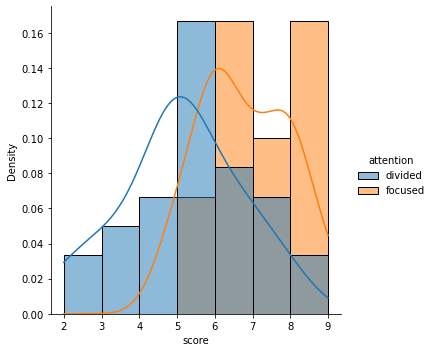

In [9]:
sns.displot(data=attention, x='score', kde=True, hue='attention', stat='density');

As can be seen by this plot, the probability that a divided participant performed very well (i.e. got a score of 7 or higher) is substantially less than the probability that a focused user performed very well. Also, the probability that focused users performed poorly (i.e. got a score of 4 or lower) is substantially smaller than the probability that distracted users performed poorly. 

It appears that focused users, on average, received better scores than non-focused users. Let's try to better visualize this trend by plotting subjects and their corresponding scores, and color-coding whether the subject was focused or not. 

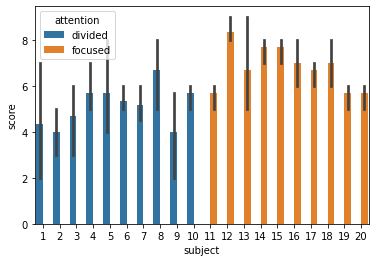

In [10]:
sns.barplot(data=attention, x='subject', y='score', hue='attention');

It appears that, on average, focused subjects appeared to perform better than non-focused subjects. Let's confirm this hypothesis by computing the average scores for the divided and focused groups. 

In [11]:
avg_scores = pd.DataFrame(attention.groupby('attention').mean()['score'])
avg_scores

,score
attention,
divided,5.116667
focused,6.800000


Indeed, we can see that the average score for divided users is around 5, while the average score for focused users is approximately 7. It appears that the average test score for focused users is about 2 points higher than that of distracted users.  



# Naive Bayes Theory

Before getting hands-on experience using the Naive Bayes Classifier, it will be useful to explain the theory underlying this classifier. 

Naive Bayes is based on Bayes' Rule, which can be stated as follows: 

$$\huge{P(A|B) = \frac{P(A) P(B|A)}{P(B)}}$$

Where  
P(A|B) is the probability that event A occurs given that event B has already occurred.  
P(A) is the probability of event A occurring.  
P(B|A) is the probability that event B occurs given that event A has already occurred.  
P(B) is the probability of event B occurring. 

A Naive Bayes Classifier is designed to classify a given observation into one of several classes. In order to do so, the Naive Bayes Classifier relies heavily on Bayes theorem. Specifically, given a specific feature of the dataset, the Naive Bayes Classifier computes the probability of the observation falling into each of the different classes based on the value of the feature. Then, this classifier takes the highest such probability, and classifies the observation as falling into the class which matches with that largest probability. 

One important consideration is that the Naive Bayes classifier assumes that features are conditionally independent of one another. This means that when using multiple features in order to predict which class an observation falls into, the Naive Bayes Classifier assumes that none of the features depend on each other. 

 # Naive Bayes Classifier

Let's now use a Naive Bayes classifier to predict whether a participant is distracted or not based on their score. We can drop the other columns, since they won't be relevant. 

In [12]:
attention_nb = attention[['attention', 'score']]
attention_nb.head()

,attention,score
0,divided,2.0
1,divided,3.0
2,divided,3.0
3,divided,5.0
4,divided,4.0


Next, perform a train-test split. Since the dataset is small, let's choose 80% of the samples to be in the training set and 20% of the samples to be in the test set. 

In [13]:
from sklearn.model_selection import train_test_split

X = attention_nb[['score']]
y = attention_nb['attention']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [14]:
X_train.shape
X_test.shape
y_train.shape
y_test.shape

(12,)

Now, let's instantiate the model and fit the data to the model. We will use a Gaussian Naive Bayes classifier, which assumes that the distribution of continuous features is Gaussian. This appears to be a reasonable assumption in the case of the test scores. 

In [15]:
from sklearn.naive_bayes import GaussianNB

nb_gauss = GaussianNB()
nb_gauss.fit(X_train, y_train);

Let's evaluate the accuracy on our testing set. 

In [16]:
predictions = nb_gauss.predict(X_test)

In [17]:
from sklearn.metrics import accuracy_score as accuracy
round(accuracy(y_test, predictions), 2)

0.75

In [18]:
predictions

array(['divided', 'divided', 'focused', 'focused', 'focused', 'focused',
       'focused', 'focused', 'focused', 'focused', 'focused', 'focused'],
      dtype='<U7')

75% is actually quite good, considering how few samples were used to train the model. We can plot a confusion matrix to get a better sense for which samples the model misclassified. 

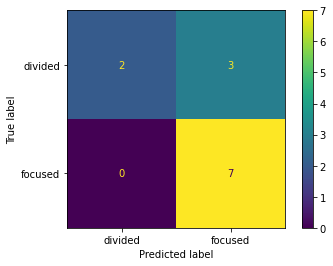

In [19]:
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

labels_arr = ['divided', 'focused']
conf_matrix = metrics.confusion_matrix(y_test, predictions, labels=labels_arr)
cm = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['divided', 'focused'])
cm.plot();

It appears that the Gaussian NB classifier over-predicted samples as being focused. The three samples in the upper right quadrant were predicted as being focused, but were in fact divided. 


# Attributions

1. https://seaborn.pydata.org/generated/seaborn.barplot.html
2. https://www.geeksforgeeks.org/python-pandas-dataframe-groupby/
3. https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
4. https://scikit-learn.org/stable/modules/naive_bayes.html
5. https://www.datacamp.com/tutorial/naive-bayes-scikit-learn